In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import sys
sys.path.append("../src/")
import jax.numpy as jnp
import jax
import jax.tree_util as jtu
import genjax
from genjax import gen, Target, smc
from genjax import ChoiceMapBuilder as C
from config import *
from IPython.display import HTML
genjax.pretty()

In [45]:
from maskcombinator_model import multifirefly_model
from utils import *
multi_model_jit = jax.jit(multifirefly_model.importance)

In [46]:
key = jax.random.PRNGKey(777)
key, subkey = jax.random.split(key)
max_fireflies = jnp.arange(1, 5)

constraint = C["n_fireflies"].set(2) ^ C["steps", :, "dynamics", :, "blink"].set(jnp.array([[1, 1, 1, 1], [1, 1, 1, 1,]]))
time_mask = jnp.arange(TIME_STEPS) < TIME_STEPS # Number of time steps to simulate
tr, w = multi_model_jit(subkey, constraint, (max_fireflies, time_mask,))

chm = tr.get_sample()
print(chm)

Static({'init': Indexed(c=Static({'blink_rate': Choice(v=Mask(value=<jax.Array float32(4,) ≈0.1 ±0.0075 [≥0.092, ≤0.11] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>)), 'vx': Choice(v=Mask(value=<jax.Array float32(4,) ≈0.28 ±1.1 [≥-1.6, ≤1.0] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>)), 'vy': Choice(v=Mask(value=<jax.Array float32(4,) ≈-0.64 ±0.51 [≥-1.4, ≤-0.06] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>)), 'x': Choice(v=Mask(value=<jax.Array float32(4,) ≈2.4e+01 ±9.2 [≥7.9, ≤3e+01] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>)), 'y': Choice(v=Mask(value=<jax.Array float32(4,) ≈1.4e+01 ±9.6 [≥4.5, ≤3e+01] nonzero:4>, flag=<jax.Array bool(4,) true:2 false:2>))}), addr=None), 'n_fireflies': Choice(v=<jax.Array(2, dtype=int32, weak_type=True)>), 'steps': Indexed(c=Static({'dynamics': Indexed(c=Static({'blink': Choice(v=Mask(value=<jax.Array int32(2, 4) [≥1, ≤1] nonzero:8>, flag=<jax.Array bool(2, 4) true:4 false:4>)), 'vx': Choice(v=Mask(value=<jax.Arr

In [47]:
anim = animate(list(chm["steps", :, "observations", "pixels"].value), 20)
HTML(anim.to_jshtml())

Try running SIR with 10,000 samples

In [87]:
importance = jax.jit(jax.vmap(multifirefly_model.importance, in_axes=(0, None, None)))
pixels = chm["steps", :, "observations", "pixels"]
# address = ["steps", :, "observations", "pixels"]

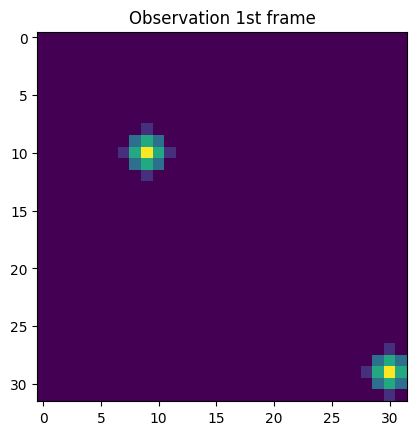

Average Weight after 10000 runs:     
Weight (1 firefly): -53175.359375,     
Weight (2 fireflies): -57349.35546875,     
Weight (4 fireflies): -65366.30859375


In [ ]:
# Bad hypothesis
scores = {"bad": 0, "good": 0, "ok": 0}
runs = 10000
keys = jax.random.split(subkey, runs)

bad_constraints = C["n_fireflies"].set(jnp.array(1)) ^ C["steps", :, "observations", "pixels"].set(pixels)
bad_chm, bad_hyp_weight = importance(keys, bad_constraints, (max_fireflies, time_mask,))

    # Correct hypothesis
keys = jax.random.split(keys[-1], runs)
good_constraints = C["n_fireflies"].set(jnp.array(2)) ^ C ["steps", :, "observations", "pixels"].set(pixels) 
                    #\ ^ C["steps", :, "dynamics", :, "x"].set(chm["steps", :, "dynamics", :, "x"].value)
good_chm, good_hyp_weight = importance(keys, good_constraints, (max_fireflies, time_mask,))

# Possible hypothesis
keys = jax.random.split(keys[-1], runs)
ok_constraints = C["n_fireflies"].set(jnp.array(4)) ^ C ["steps", :, "observations", "pixels"].set(pixels)
                    #\ ^ C["steps", :, "dynamics", :, "x"].set(chm["steps", :, "dynamics", :, "x"].value)
ok_chm, ok_hyp_weight = importance(keys, ok_constraints, (max_fireflies, time_mask,))

scores["bad"] += bad_hyp_weight
scores["good"] += good_hyp_weight
scores["ok"] += ok_hyp_weight


plt.imshow(chm["steps", :, "observations", "pixels"].value[4], vmin=0, vmax=1)
plt.title("Observation 1st frame")
plt.show()
print(f"Average Weight after {runs} runs: \
    \nWeight (1 firefly): {bad_hyp_weight.mean()}, \
    \nWeight (2 fireflies): {good_hyp_weight.mean()}, \
    \nWeight (4 fireflies): {ok_hyp_weight.mean()}")

In [94]:
good_chm.get_choices()

StaticTrace(
  gen_fn=StaticGenerativeFunction(
    source=Closure(
      dyn_args=(),
      fn=<function multifirefly_model at 0x7f6cc53536a0>,  # Defined at line 144 of /home/yonifriedman/fireflies-mot/experiments/../src/maskcombinator_model.py
    ),
  ),
  args=(
    <jax.Array int32(10000, 4) [≥1, ≤4] nonzero:40_000>,
    <jax.Array bool(10000, 2) true:20_000>,
  ),
  retval=(
    (Mask(value={'blink_rate': <jax.Array float32(10000, 4) ≈0.1 ±0.01 [≥0.059, ≤0.14] nonzero:40_000>, 'blinking': <jax.Array int32(10000, 4) [≥0, ≤1] zero:32_897 nonzero:7_103>, 'state_duration': <jax.Array int32(10000, 4) [≥1, ≤2] nonzero:40_000>, 'vx': <jax.Array float32(10000, 4) ≈-0.024 ±0.98 [≥-2.0, ≤2.0] nonzero:40_000>, 'vy': <jax.Array float32(10000, 4) ≈-0.025 ±0.98 [≥-2.0, ≤2.0] nonzero:40_000>, 'x': <jax.Array float32(10000, 4) ≈1.7e+01 ±8.9 [≥0.0037, ≤3.2e+01] nonzero:40_000>, 'y': <jax.Array float32(10000, 4) ≈1.6e+01 ±8.9 [≥0.014, ≤3.2e+01] nonzero:40_000>}, flag=<jax.Array bool(10000, 4) true:20_000 false:20_000>), <jax.Array float32(10000, 32, 32)>),
    None,
  ),
  addresses=AddressVisitor(
    visited=[('n_fireflies',), ('init',), ('steps',)],
  ),
  subtraces=[DistributionTrace(gen_fn=LabeledCategorical(), args=(<jax.Array float32(10000, 4) ≈0.25 ±0.0 [≥0.25, ≤0.25] nonzero:40_000>, <jax.Array int32(10000, 4) [≥1, ≤4] nonzero:40_000>), value=<jax.Array int32(10000,) [≥2, ≤2] nonzero:10_000>, score=<jax.Array float32(10000,) ≈-1.4 ±3.6e-07 [≥-1.4, ≤-1.4] nonzero:10_000>), VmapTrace(gen_fn=VmapCombinator(gen_fn=MaskCombinator(gen_fn=StaticGenerativeFunction(source=Closure(dyn_args=(), fn=<function init_firefly at 0x7f6cc4a77060>))), in_axes=0), inner=MaskTrace(mask_combinator=MaskCombinator(gen_fn=StaticGenerativeFunction(source=Closure(dyn_args=(), fn=<function init_firefly at 0x7f6cc4a77060>))), inner=StaticTrace(gen_fn=StaticGenerativeFunction(source=Closure(dyn_args=(), fn=<function init_firefly at 0x7f6cc4a77060>)), args=(), retval={'blink_rate': <jax.Array float32(10000, 4) ≈0.1 ±0.01 [≥0.059, ≤0.14] nonzero:40_000>, 'blinking': <jax.Array int32(10000, 4) [≥0, ≤0] zero:40_000>, 'state_duration': <jax.Array int32(10000, 4) [≥0, ≤0] zero:40_000>, 'vx': <jax.Array float32(10000, 4) ≈-0.0026 ±0.88 [≥-2.0, ≤2.0] nonzero:40_000>, 'vy': <jax.Array float32(10000, 4) ≈0.0014 ±0.88 [≥-2.0, ≤2.0] nonzero:40_000>, 'x': <jax.Array float32(10000, 4) ≈1.7e+01 ±8.9 [≥1.0, ≤3.2e+01] nonzero:40_000>, 'y': <jax.Array float32(10000, 4) ≈1.7e+01 ±8.9 [≥1.0, ≤3.2e+01] nonzero:40_000>}, addresses=AddressVisitor(visited=[('x',), ('y',), ('vx',), ('vy',), ('blink_rate',)]), subtraces=[DistributionTrace(gen_fn=ExactDensityFromCallables(sampler=Closure(dyn_args=(), fn=<function tfp_distribution.<locals>.sampler at 0x7f6cd3a89080>), logpdf_evaluator=Closure(dyn_args=(), fn=<function tfp_distribution.<locals>.logpdf at 0x7f6cd3a89120>)), args=(<jax.Array float32(10000, 4) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:40_000>, <jax.Array float32(10000, 4) ≈3.2e+01 ±0.0 [≥3.2e+01, ≤3.2e+01] nonzero:40_000>), value=<jax.Array float32(10000, 4) ≈1.7e+01 ±8.9 [≥1.0, ≤3.2e+01] nonzero:40_000>, score=<jax.Array float32(10000, 4) ≈-3.4 ±2.4e-07 [≥-3.4, ≤-3.4] nonzero:40_000>), DistributionTrace(gen_fn=ExactDensityFromCallables(sampler=Closure(dyn_args=(), fn=<function tfp_distribution.<locals>.sampler at 0x7f6cd3a89080>), logpdf_evaluator=Closure(dyn_args=(), fn=<function tfp_distribution.<locals>.logpdf at 0x7f6cd3a89120>)), args=(<jax.Array float32(10000, 4) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:40_000>, <jax.Array float32(10000, 4) ≈3.2e+01 ±0.0 [≥3.2e+01, ≤3.2e+01] nonzero:40_000>), value=<jax.Array float32(10000, 4) ≈1.7e+01 ±8.9 [≥1.0, ≤3.2e+01] nonzero:40_000>, score=<jax.Array float32(10000, 4) ≈-3.4 ±2.4e-07 [≥-3.4, ≤-3.4] nonzero:40_000>), DistributionTrace(gen_fn=ExactDensityFromCallables(sampler=Closure(dyn_args=(), fn=<function tfp_distribution.<locals>.sampler at 0x7f6cd3a88f40>), logpdf_evaluator=Closure(dyn_args=(), fn=<function tfp_distribution.<locals>.logpdf at 0

(0.0, 32.0)

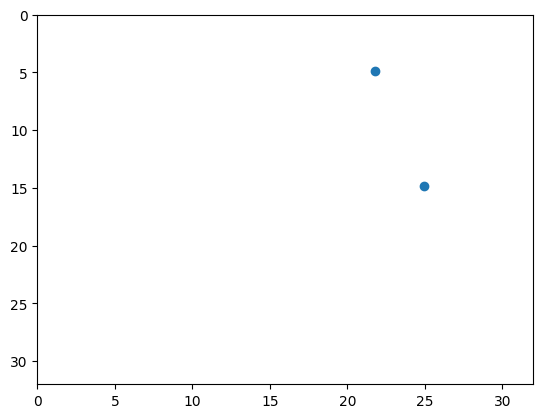

In [102]:
good_hyp_x = good_chm.get_choices()["steps", :, "dynamics", :, "x"].value[0, 1, :2]
good_hyp_y = good_chm.get_choices()["steps", :, "dynamics", :, "y"].value[0, 1, :2]

plt.scatter(good_hyp_x, good_hyp_y)
plt.ylim(32, 0)
plt.xlim(0, 32)


In [27]:
N = 10000
K = 100

def SIR(N, K, model, chm):
    @jax.jit
    def _inner(key, args):
        key, subkey = jax.random.split(key)
        traces, weights = jax.vmap(model.importance, in_axes=(0, None, None))(
            jax.random.split(key, N), chm, args
        )
        idxs = jax.vmap(jax.jit(genjax.categorical.simulate), in_axes=(0, None))(
            jax.random.split(subkey, K), (weights,)
        ).get_retval()
        samples = traces.get_sample()
        resampled_samples = jax.vmap(lambda idx: jtu.tree_map(lambda v: v[idx], samples))(
            idxs
        )
        return resampled_samples

    return _inner

In [28]:
constraints = C["steps", :, "observations", "pixels"].set(chm["steps", :, "observations", "pixels"])
args = (max_fireflies, time_mask,)
key, subkey = jax.random.split(key)
samples = jax.jit(SIR(N, K, multifirefly_model, constraints))(subkey, args)

In [31]:
print(samples["steps", :, "dynamics", :, "x"].value[:, :, 0].mean(axis=0))
print(samples["steps", :, "dynamics", :, "x"].value[:, :, 0].std(axis=0))
print(samples["n_fireflies"].mean(), samples["n_fireflies"].std())

[9.145634 8.980669]
[1.04904175e-05 1.14440918e-05]
1.0 0.0


In [30]:
# Visualize draws from SIR
def animate_latents(tr):
    xs = get_masked_values(tr["steps", :, "dynamics", :, "x"], fill_value=-1)
    ys = get_masked_values(tr["steps", :, "dynamics", :, "y"], fill_value=-1)
    blinks = get_masked_values(tr["steps", :, "dynamics", :, "blink"], fill_value=False)
    pixels = tr["steps", :, "observations", "pixels"].value
    anim = animate_fireflies_with_images(pixels, xs, ys, blinks, fps=10, use_particle_colors=False, mask_value=-1)
    return HTML(anim.to_jshtml())

animate_latents(samples)